# Setups

In [21]:
import os
import time
import sys

import numpy as np
import pandas
from skimage import io, transform
import matplotlib.pyplot as plt
import tqdm
import albumentations as Alb
import tifffile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset

# Config

In [22]:
class CFG:
    """
    Configuration class for the blood vessel segmentation project.
    """

    # ============== Model Configuration =============
    MODEL_NAME = 'Unet'
    BACKBONE = 'se_resnext50_32x4d'
    IN_CHANNEL = 1  # Number of input channels (e.g., 1 for grayscale images)
    OUT_CHANNEL = 1 # Number of output channels

    # ============== Image Processing Settings =============
    INPUT_IMAGE_SIZE = (1024, 1024)  # Size of the input images (height x width)
    
    # =============
    # = Training and Validation Parameters =============
    VALID_ID = 1  # ID for validation dataset or fold
    BATCH_SIZE = 16  # Batch size for model training
    THRESHOLD_PERCENTILE = 0.0014109  # Threshold for post-processing
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 50
    NUM_WORKERS = 0 # Number of threds

    # ============== Model Paths =============
    # List of paths to trained model weights
    MODEL_PATHS = [
        "/path/to/model1.pt",
        "/path/to/model2.pt",
        # Add more model paths as needed
    ]

    # ============== Data Paths =============
    DATASET_NAME = "kidney_1_dense"
    DATASET_DIRECTORY = os.path.join("..", "data")
    TRAIN_DATASET_DIRECTORY = os.path.join(DATASET_DIRECTORY, "train", DATASET_NAME)
    TEST_DATASET_DIRECTORY = os.path.join(DATASET_DIRECTORY, "test", DATASET_NAME)

# 2. Custom Dataset Class

In [23]:
class CustomDataset(Dataset):
    def __init__(self, image_path, target_image_size):
        self.image_path = image_path
        self.target_image_size = target_image_size
        self.image_filenames = sorted([os.path.join(image_path, filename) for filename in os.listdir(image_path) if filename.endswith('.tif')])
        print(f"{len(self.image_filenames)} samples are loaded.")

    def __getitem__(self, index):
        # Load image
        image = io.imread(self.image_filenames[index])

        # Resize and pad the image
        image = self.resize_and_pad(image, self.target_image_size)

        # Extract the filename
        image_filename = os.path.basename(self.image_filenames[index])
        return image, image_filename

    def __len__(self):
        return len(self.image_filenames)

    def resize_and_pad(self, image, target_image_size):
        """Resize an image and add padding to keep aspect ratio."""
        # Calculate scale and padding
        h, w = image.shape[:2]
        scale = min(target_image_size[0] / h, target_image_size[1] / w)
        new_h, new_w = int(h * scale), int(w * scale)
        pad_h = (target_image_size[0] - new_h) // 2
        pad_w = (target_image_size[1] - new_w) // 2

        # Resize image
        image_resized = transform.resize(image, (new_h, new_w), anti_aliasing=True)

        # Initialize padded image
        if len(image.shape) == 2:  # Grayscale image
            padded_image = np.zeros((target_image_size[0], target_image_size[1]), dtype=image_resized.dtype)
        else:
            padded_image = np.zeros((target_image_size[0], target_image_size[1], image.shape[2]), dtype=image_resized.dtype)

        # Insert the resized image
        padded_image[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = image_resized

        return padded_image

# Image

In [28]:

def display_image(image, title):
    if isinstance(image, torch.Tensor):
        # If the input is a PyTorch tensor
        if len(image.shape) == 4:
            image = image.squeeze(0)

        numpy_image = image.cpu().numpy()

        if len(numpy_image.shape) == 3 and numpy_image.shape[0] == 1:
            numpy_image = numpy_image.squeeze(0)

        if len(numpy_image.shape) == 3:
            numpy_image = numpy_image.transpose(1, 2, 0)

    elif isinstance(image, np.ndarray):
        # If the input is a NumPy array
        numpy_image = image

        if len(numpy_image.shape) == 3 and numpy_image.shape[0] == 1:
            numpy_image = numpy_image.squeeze(0)
    
    plt.imshow(numpy_image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

2279 samples are loaded.
2279 samples are loaded.
(1024, 1024)


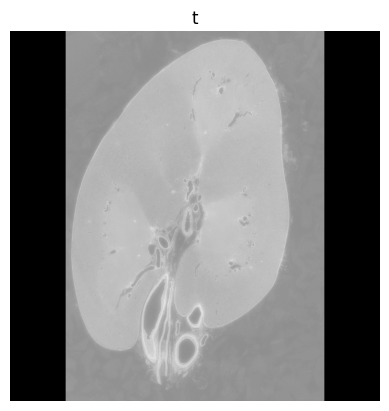

In [29]:

# first_image = tifffile.imread(image_files[981])
# first_label = tifffile.imread(label_files[981])

# is_image = isinstance(first_image, np.ndarray)
# is_mask = isinstance(first_label, np.ndarray)
# print(is_image, is_mask)

# # Convert tensor floats32
# first_image_tensor = torch.from_numpy(first_image.astype(np.float32))
# first_label_tensor = torch.from_numpy(first_label.astype(np.float32))

# display_image(first_image_tensor)
# display_image(first_label_tensor)

# is_image_tensor = isinstance(first_image_tensor, torch.Tensor)
# is_mask_tensor = isinstance(first_label_tensor, torch.Tensor)
# print(is_image_tensor, is_mask_tensor)

image_path = os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "images")
mask_path = os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "labels")
image_dataset = CustomDataset(image_path, CFG.INPUT_IMAGE_SIZE)
mask_dataset = CustomDataset(mask_path, CFG.INPUT_IMAGE_SIZE)
print(image_dataset[0][0].shape)
display_image(image_dataset[900][0], "t")

### 0.1 Image Augmentation

In [30]:
def Augement_image(image, mask):

    image_dense = torch.from_numpy(image.astype(np.float32))
    mask_dense = torch.from_numpy(mask.astype(np.float32))

    if len(image_dense.shape) == 2:
        image_dense = image_dense.unsqueeze(0)

    image_np = image_dense.permute(1, 2, 0).numpy()
    mask_np = mask_dense.numpy()

    image_list = [None, None, None, None]
    mask_list = [None, None, None, None]
    
    transform_rotate_90 = Alb.Compose([
        Alb.Rotate(limit=90, p=0.5)
    ])

    # Original image
    image_list[0] = image_np
    mask_list[0] = mask_np

    # Original image with 90-degree rotation
    augmented_rotate_90 = transform_rotate_90(image=image_np, mask=mask_np)
    image_list[1], mask_list[1] = augmented_rotate_90['image'], augmented_rotate_90['mask']

    # Original image with 180-degree rotation
    augmented_rotate_180 = transform_rotate_90(image=image_list[1], mask=mask_list[1])   
    image_list[2], mask_list[2] = augmented_rotate_180['image'], augmented_rotate_180['mask']

    # Original image with 270-degree rotation
    augmented_rotate_270 = transform_rotate_90(image=image_list[2], mask=mask_list[2])
    image_list[3], mask_list[3] = augmented_rotate_270['image'], augmented_rotate_270['mask']

    # Making the mask dimentions 3
    for i in range(4):
        if mask_list[i].ndim == 2:
            mask_list[i] = mask_list[i][..., np.newaxis]

    augmented_data_zip = list(zip(*[image_list, mask_list]))

    return augmented_data_zip

In [43]:
data_set = 'kidney_2'

image_path = os.path.join('..', 'data', 'train', data_set, 'images')
label_path = os.path.join('..', 'data', 'train', data_set, 'labels')

image_files = sorted([os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.tif')])
label_files = sorted([os.path.join(label_path, f) for f in os.listdir(label_path) if f.endswith('.tif')])

# Load an example image and label
first_image = tifffile.imread(image_files[981])
first_label = tifffile.imread(label_files[981])

# Augment the image and label
# augmented_image, augmented_mask = Augement_image(first_image, first_label)
augmented_zip = Augement_image(first_image, first_label)

# Show the augmented image
# display_image(augmented_image)
# display_image(augmented_mask)

# is_image_tensor = isinstance(augmented_image, np.ndarray)
# is_mask_tensor = isinstance(augmented_mask, np.ndarray)
# print(is_image_tensor, is_mask_tensor)
# print(augmented_zip)
# display_image(augmented_zip[-1][-1])

### Load Datasets

In [44]:
# Define loaders
train_loader = DataLoader(
    dataset=augmented_zip,   # using subset
    batch_size=4,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

for batch_idx, (batch_images, batch_masks) in enumerate(train_loader):
    print(f"Batch {batch_idx}:")
    print(f"  Image shapes: {[img.shape for img in batch_images]}")
    print(f"  Mask shapes: {[mask.shape for mask in batch_masks]}")

Batch 0:
  Image shapes: [torch.Size([1041, 1511, 1]), torch.Size([1041, 1511, 1]), torch.Size([1041, 1511, 1]), torch.Size([1041, 1511, 1])]
  Mask shapes: [torch.Size([1041, 1511, 1]), torch.Size([1041, 1511, 1]), torch.Size([1041, 1511, 1]), torch.Size([1041, 1511, 1])]


# RLE Encoding & Decoding

In [36]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    if rle == '':
        rle = '1 0'
    return rle

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# Model

## 1.1 Convolution Block

In [ ]:
""" Convolution Block """
class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=(3, 3), padding=1)
        self.bn1 = nn.BatchNorm2d(out_channel)

        self.relu = nn.ReLU()

        self.conv2 = nn.Conv2d(out_channel, out_channel, kernal_size=(3, 3), padding=1)
        self.bn2 = nn.BatchNorm2d(out_channel)


    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

## 1.2 Encoder Block

In [ ]:
""" Encoder Block """
class EncoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.conv = ConvBlock(in_channel, out_channel)
        self.pool = nn.MaxPool2d(kernal_size=(2, 2))


    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

## 1.3 Decoder Block

In [45]:
""" Decoder Block """
class DecoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_channel, out_channel, kernel_size=(2, 2), stride=2, padding=0)
        self.conv = ConvBlock(in_channel, out_channel)


    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)

        return x

## 1.4 Attention Block

In [47]:
class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, F_i):
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, F_i, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_i)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_i, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_i)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_i, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, X):
        g1 = self.W_gate(gate)
        x1 = self.W_x(X)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = X * psi
        return out


## 1.5 VGG

In [48]:

class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers):
        super(VGGBlock, self).__init__()

        layers = []
        for _ in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels

        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.vgg_block = nn.Sequential(*layers)

    def forward(self, x):
        return self.vgg_block(x)

class VGGNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(VGGNet, self).__init__()

        self.encoder = nn.Sequential(
            VGGBlock(in_channels, 64, 2),
            VGGBlock(64, 128, 2),
            VGGBlock(128, 256, 3),
            VGGBlock(256, 512, 3),
            VGGBlock(512, 512, 3)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            VGGBlock(512, 256, 3),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            VGGBlock(256, 128, 2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            VGGBlock(128, 64, 2),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            VGGBlock(64, 32, 2)
        )

        self.attention_block = AttentionBlock(512, 256, 256)  # Assuming attention between encoder and decoder

        self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1)

    def forward(self, x):
        encoder_outputs = []

        # Encoder
        for block in self.encoder:
            x = block(x)
            encoder_outputs.append(x)

        # Attention between encoder and decoder
        attention_output = self.attention_block(encoder_outputs[-1], encoder_outputs[-2])

        # Decoder
        x = self.decoder(attention_output)

        # Final convolution
        x = self.final_conv(x)

        return x

# Example usage:
in_channels = 3  # Assuming input images have 3 channels (e.g., RGB)
num_classes = 1  # Number of segmentation classes
model = VGGNet(in_channels, num_classes)